In [17]:

import os
import sys
from IPython.display import  display
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath(os.path.join('../scripts')))

import plots
from sklearn import preprocessing
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings('ignore')

sns.set()

In [18]:
from file_handler import FileHandler


In [19]:
file_handler = FileHandler()

In [21]:
train_df = file_handler.read_csv("../data/train.csv")
store_df = file_handler.read_csv("../data/store.csv")
test_df = file_handler.read_csv("../data/test.csv")

In [24]:
class CleanTrainData:
   
    def __init__(self):
        pass
    
    def to_numeric(self, df):
        df["Customers"] = df["Customers"].astype("int")
        df["Sales"] = df["Sales"].astype("int")
        return df
        
    def to_category(self, df):
        
        df["Open"] = df["Open"].astype("category")
        df["DayOfWeek"] = df["Open"].astype("category")
        df["Promo"] = df["Promo"].astype("category")
        df["StateHoliday"] = df["StateHoliday"].astype("category")
        df["SchoolHoliday"] = df["SchoolHoliday"].astype("category")
        df['StateHoliday'] = df['StateHoliday'].astype("str").astype("category")
        return df
    
    def drop_closed_stores(self, df):
        
        try:
            cleaned = df.query("Open == 1")
            return cleaned
        except:
            pass
        
    def convert_to_datatime(self, df):  
        try:
            df['Date'] = pd.to_datetime(train_df['Date'])
            return df
        except:
            pass
    
    def sort_by_date(self, df):
        return df.sort_values(by=["Date"], ascending=False)     
    
        
    def get_cleaned(self, df):
        df = self.to_category(df)
        df = self.to_numeric(df)
#         df = self.drop_closed_stores(df)
        df = self.convert_to_datatime(df)

        return df
     
   
   
    def __init__(self):
        pass
    
    def to_numeric(self, df):
        df["Customers"] = df["Customers"].astype("int")
        df["Sales"] = df["Sales"].astype("int")
        return df
        
    def to_category(self, df):
        
        df["Open"] = df["Open"].astype("category")
        df["DayOfWeek"] = df["Open"].astype("category")
        df["Promo"] = df["Promo"].astype("category")
        df["StateHoliday"] = df["StateHoliday"].astype("category")
        df["SchoolHoliday"] = df["SchoolHoliday"].astype("category")
        df['StateHoliday'] = df['StateHoliday'].astype("str").astype("category")
        return df
    
    def drop_closed_stores(self, df):
        
        try:
            cleaned = df.query("Open == 1")
            return cleaned
        except:
            pass
        
    def convert_to_datatime(self, df):  
        try:
            df['Date'] = pd.to_datetime(train_df['Date'])
            return df
        except:
            pass
    
    def sort_by_date(self, df):
        return df.sort_values(by=["Date"], ascending=False)     
    
        
    def get_cleaned(self, df):
        df = self.to_category(df)
        df = self.to_numeric(df)

        df = self.convert_to_datatime(df)

        return df

In [25]:
class PreprocessRossmanData:
    
    def __init__(self):
        pass
    
        
    def handle_outliers(self, df, col, method="lower_upper"):
        
        df = df.copy()
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)

        lower_bound = q1 - ((1.5) * (q3 - q1))
        upper_bound = q3 + ((1.5) * (q3 - q1))

        if method == "mean":
            df[col] = np.where(df[col] < lower_bound,   df[col].mean(), df[col])
            df[col] = np.where(df[col] > upper_bound, df[col].mean(), df[col])

        elif  method == "mode":
            df[col] = np.where(df[col] < lower_bound,   df[col].mode()[0], df[col])
            df[col] = np.where(df[col] > upper_bound, df[col].mode()[0], df[col])
        else:
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

        return df
    
    def transform_date(self, df):
        
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = pd.DatetimeIndex(df['Date']).year
        df['Month'] = pd.DatetimeIndex(df['Date']).month
        df['Day'] = pd.DatetimeIndex(df['Date']).day
        
        df['Year'] = df['Year'].astype("category")
        df['Month'] = df['Month'].astype("category")
        df['Day'] = df['Day'].astype("category")
        df['DayInMonth'] = df['Day'].apply(lambda x: self.to_month_category(x))
        df['DayInMonth'] =  df['DayInMonth'].astype("category")
        return df
    
    def to_month_category(self, value):
        try:
            if (value >= 1 and int(value) < 10):
                return "BegMonth"

            elif (value >= 10 and value < 20):
                return "MidMonth"
            else:
                return "EndMonth"
        except:
            pass
    
    def add_weekday_col(self, df):
      
        df["Weekends"] = df["DayOfWeek"].apply(lambda x: 1 if x > 5 else 0)
        df["Weekends"] = df["Weekends"].astype("category")
        return df
    
    def encode_train_data(self, df):
        
        StateHolidayEncoder = preprocessing.LabelEncoder()
        DayInMonthEncoder = preprocessing.LabelEncoder()
        
        df['StateHoliday'] = StateHolidayEncoder.fit_transform(df['StateHoliday'])
        df['DayInMonth'] = DayInMonthEncoder.fit_transform(df['DayInMonth'])
        return df
        
    def encode_store_data(self, df):
        StoreTypeEncoder = preprocessing.LabelEncoder()
        AssortmentEncoder = preprocessing.LabelEncoder()
        PromoIntervalEncoder = preprocessing.LabelEncoder()

        
#         PromoInterval
        df['StoreType'] = StoreTypeEncoder.fit_transform(df['StoreType'])
        df['Assortment'] = AssortmentEncoder.fit_transform(df['Assortment'])
        df['PromoInterval'] = PromoIntervalEncoder.fit_transform(df['PromoInterval'])

        return df
    
    def merge_encoded(self, train_enc, store_enc):
        return pd.merge(train_enc, store_enc, on="Store")
    
    def process(self, train_df, store_df):
        
        
        train_df = self.transform_date(train_df)
        train_df = self.add_weekday_col(train_df)
        
        
        
        merged = self.merge_encoded(train_df, store_df)
        
        return merged
    

In [26]:
clean_train_df = CleanTrainData().get_cleaned(train_df)
cleaned_rossman_data = PreprocessRossmanData().process(train_df, store_df)

In [27]:
def loss_function(actual, pred):
    mae = mean_absolute_error(actual, pred)
    return mae

class RossmanModelPipeline:
    
    def __init__(self, cleaned_rossman_data, model_name):  
       
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data(cleaned_rossman_data)
        self.model_name = model_name
    
    def prepare_data(self, cleaned_rossman_data):
        feat_cols = ['DayOfWeek','Promo','StateHoliday','SchoolHoliday','Year', 'Open',
                     'Month','Day','Weekends','StoreType','Assortment','CompetitionDistance',
                     'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2',
                     'Promo2SinceWeek','Promo2SinceYear',  "DayInMonth"]
        
        X = cleaned_rossman_data[feat_cols]
        y = cleaned_rossman_data["Sales"]
        return train_test_split(X, y, test_size=0.2)
    
    def Preproccessor(self):  
        cols = self.X_train.columns
        numric_cols = ["CompetitionDistance", "Promo2SinceWeek"]
        categorical_cols = self.X_train.drop(columns=numric_cols, index=1, inplace=False).columns.to_list()
        
        numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
        categorical_transformer = Pipeline(steps=[('encoder', OrdinalEncoder())])
        
        preprocessor = ColumnTransformer(
            transformers=[('numric', numeric_transformer, numric_cols),
                          ('category', categorical_transformer, categorical_cols)])
        return preprocessor
    
    def train(self, regressor=RandomForestRegressor(n_jobs=-1, n_estimators=15)):
        preprocessor = self.Preproccessor()
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', regressor)])
        

        model = pipeline.fit(self.X_train, self.y_train)
                
        return pipeline, model
    
    
    def test(self, model):
        
        predictions = model.predict(self.X_test)
        score_2 = r2_score(self.y_test, predictions)
        loss = loss_function(predictions, self.y_test)
        print(f" R2 score of model is: {score_2:.3f}")

        print(f"step Mean abs error of model is: {loss:.3f}")
        
        result_df = self.X_test.copy()
        result_df["Prediction Sales"] = predictions
        result_df["Actual Sales"] = self.y_test
        result_agg = result_df.groupby("Day").agg({"Prediction Sales": "mean", "Actual Sales":"mean"})
        
        return score_2, loss, result_agg
 
    
    def pred_graph(self, res_dataframe):
        
        fig = plt.figure(figsize=(18, 5))
        sns.lineplot(x = res_dataframe.index, y = res_dataframe["Actual Sales"], label='Actual')
        sns.lineplot(x = res_dataframe.index, y = res_dataframe["Prediction Sales"], label='Prediction')
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel(xlabel="Day", fontsize=16)
        plt.ylabel(ylabel="Sales", fontsize=16)
        plt.show()
        
        return fig
    
    def get_feature_importance(self, model):
        if (type(model.steps[1][1]) == type(LinearRegression())):
            model = model.steps[1][1]
           
            p_df = pd.DataFrame()
            p_df['features'] = self.X_train.columns.to_list()
            p_df['coff_importance'] = abs(model.coef_)
            
            return p_df
        
        importance = model.steps[1][1].feature_importances_
        f_df = pd.DataFrame(columns=["features", "importance"])
        f_df["features"] = self.X_train.columns.to_list()
        f_df["importance"] = importance
        return f_df

In [28]:
clean_train_df = CleanTrainData().get_cleaned(train_df)
cleaned_rossman_data = PreprocessRossmanData().process(train_df, store_df)

In [29]:
def loss_function(actual, pred):
    mae = mean_absolute_error(actual, pred)
    return mae

class RossmanModelPipeline:
    
    def __init__(self, cleaned_rossman_data, model_name):  
       
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data(cleaned_rossman_data)
        self.model_name = model_name
    
    def prepare_data(self, cleaned_rossman_data):
        feat_cols = ['DayOfWeek','Promo','StateHoliday','SchoolHoliday','Year', 'Open',
                     'Month','Day','Weekends','StoreType','Assortment','CompetitionDistance',
                     'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2',
                     'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval', "DayInMonth"]
        
        X = cleaned_rossman_data[feat_cols]
        y = cleaned_rossman_data["Sales"]
        return train_test_split(X, y, test_size=0.2)
    
    def Preproccessor(self):  
        cols = self.X_train.columns
        numric_cols = ["CompetitionDistance", "Promo2SinceWeek", "Year"]
        categorical_cols = self.X_train.copy(deep=True).drop(columns=numric_cols, axis=1, inplace=False).columns.to_list()
        
        numeric_transformer = Pipeline(steps=[('scaler', StandardScaler()),
                                              ('imputer', SimpleImputer(strategy='mean'))])
        categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                                  ('encoder', OrdinalEncoder())])
        
        preprocessor = ColumnTransformer(
            transformers=[('numric', numeric_transformer, numric_cols),
                          ('category', categorical_transformer, categorical_cols)])
        return preprocessor
    
    def train(self, regressor=RandomForestRegressor(n_jobs=-1, max_depth=15, n_estimators=15)):
        
        preprocessor = self.Preproccessor()
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', regressor)])
        
        mlflow.set_experiment('Rossman-' + self.model_name)
        mlflow.sklearn.autolog()
        with mlflow.start_run(run_name="Baseline"):
            model = pipeline.fit(self.X_train, self.y_train)
                
        return pipeline, model
    
    
    def test(self, model):
        
        predictions = model.predict(self.X_test)
        score_2 = r2_score(self.y_test, predictions)
        loss = loss_function(predictions, self.y_test)
        print(f" R2 score of model is: {score_2:.3f}")

        print(f"step Mean abs error of model is: {loss:.3f}")
        
        result_df = self.X_test.copy()
        result_df["Prediction Sales"] = predictions
        result_df["Actual Sales"] = self.y_test
        result_agg = result_df.groupby("Day").agg({"Prediction Sales": "mean", "Actual Sales":"mean"})
        
        return score_2, loss, result_agg
 
    
    def pred_graph(self, res_dataframe):
        
        fig = plt.figure(figsize=(18, 5))
        sns.lineplot(x = res_dataframe.index, y = res_dataframe["Actual Sales"], label='Actual')
        sns.lineplot(x = res_dataframe.index, y = res_dataframe["Prediction Sales"], label='Prediction')
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel(xlabel="Day", fontsize=16)
        plt.ylabel(ylabel="Sales", fontsize=16)
        plt.show()
        
        return fig
    
    def get_feature_importance(self, model):
        if (type(model.steps[1][1]) == type(LinearRegression())):
            model = model.steps[1][1]
           
            p_df = pd.DataFrame()
            p_df['features'] = self.X_train.columns.to_list()
            p_df['coff_importance'] = abs(model.coef_)
            
            return p_df
        
        importance = model.steps[1][1].feature_importances_
        f_df = pd.DataFrame(columns=["features", "importance"])
        f_df["features"] = self.X_train.columns.to_list()
        f_df["importance"] = importance
        return f_df

#### Sales Prediction Using RandomForset Regressor

In [30]:
rossPipeLine = RossmanModelPipeline(cleaned_rossman_data, "RandomForset-2")
pipeline, model = rossPipeLine.train()

2022/05/30 22:37:53 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/30 22:37:53 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('numric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('imputer', SimpleImputer())]),
                          ...`
2022/05/30 22:37:53 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('numric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('imputer', SimpleImputer())]),
                                 ['Competiti...`
2022/05/30 22:37:53 WARNING mlflow.utils: Truncated

 R2 score of model is: 0.843
step Mean abs error of model is: 1007.813


,Prediction Sales,Actual Sales
Day,,
1,4415.408797,4710.488826
2,6621.140561,6993.679299
3,5647.634732,5793.972866
4,6616.738762,6814.922685
5,6392.486608,6400.663037
6,6047.099700,5937.885479
7,6050.276839,5997.285948
8,5729.548872,5625.836377
9,5375.508571,5273.006168


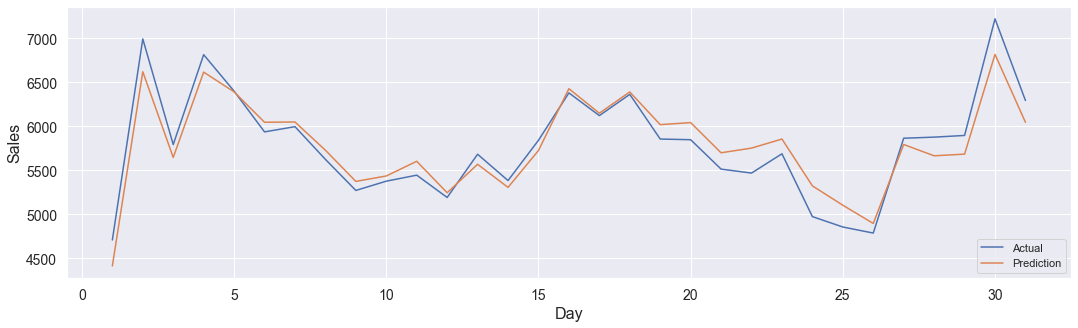

In [31]:
score, loss, res_df = rossPipeLine.test(model)
display(res_df)
fig = rossPipeLine.pred_graph(res_df)

In [32]:
random_feat_imp = rossPipeLine.get_feature_importance(model).sort_values(by=["importance"], ascending=False)
display(random_feat_imp)

,features,importance
3,SchoolHoliday,0.294793
7,Day,0.257264
0,DayOfWeek,0.131743
4,Year,0.087888
14,Promo2,0.049147
13,CompetitionOpenSinceYear,0.043892
11,CompetitionDistance,0.023529
12,CompetitionOpenSinceMonth,0.020188
9,StoreType,0.019506
8,Weekends,0.018414


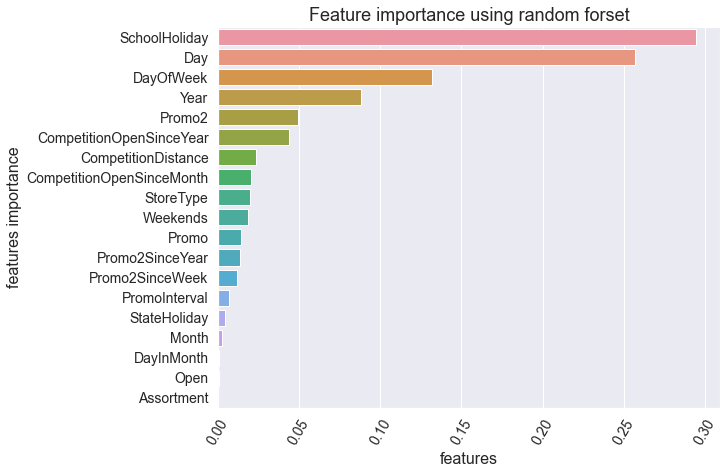

In [33]:
plots.plot_bar(random_feat_imp,  "importance", "features","Feature importance using random forset", "features",
               "features importance")

In [34]:
import datetime
timestamp = str(datetime.datetime.now())

In [35]:
rossPipeLine_2 = RossmanModelPipeline(cleaned_rossman_data, "LinearRegression")
pipeline_2, model_2 = rossPipeLine_2.train(regressor= LinearRegression())

2022/05/30 22:39:35 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/30 22:39:35 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('numric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('imputer', SimpleImputer())]),
                          ...`
2022/05/30 22:39:36 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('numric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('imputer', SimpleImputer())]),
                                 ['Competiti...`
2022/05/30 22:39:36 WARNING mlflow.utils: Truncated

 R2 score of model is: 0.553
step Mean abs error of model is: 1782.616


,Prediction Sales,Actual Sales
Day,,
1,4404.569008,4717.378734
2,6432.758622,7050.704316
3,5668.131564,5746.789108
4,6637.954344,6806.690844
5,6429.915344,6402.961521
6,6166.641761,5927.310626
7,6121.984850,6033.721216
8,5939.582803,5696.861488
9,5442.032512,5237.310438


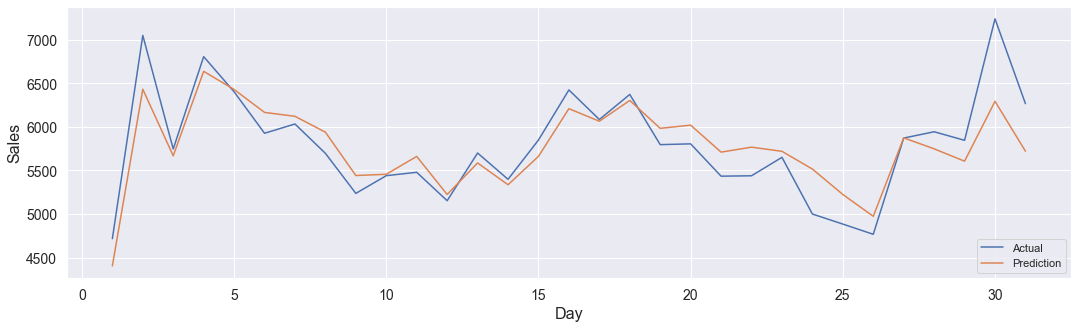

In [36]:
score_2, loss_2, res_df_2 = rossPipeLine_2.test(model_2)
display(res_df_2)
fig = rossPipeLine_2.pred_graph(res_df_2)

In [37]:
lr_feat_imp = rossPipeLine_2.get_feature_importance(model_2).sort_values(by=["coff_importance"], ascending=False)
display(lr_feat_imp)

,features,coff_importance
7,Day,2.621796e+13
3,SchoolHoliday,2.621796e+13
10,Assortment,4.019814e+09
4,Year,2.180787e+03
15,Promo2SinceWeek,6.678610e+02
5,Open,3.831276e+02
12,CompetitionOpenSinceMonth,3.443841e+02
1,Promo,2.300286e+02
0,DayOfWeek,1.890369e+02
6,Month,1.571235e+02


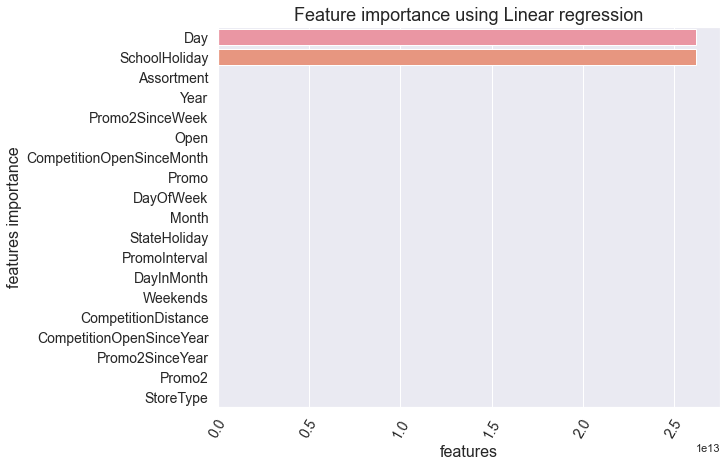

In [40]:
plots.plot_bar(lr_feat_imp,  "coff_importance", "features","Feature importance using Linear regression", "features",
               "features importance")

In [ ]:
rossPipeLine_3 = RossmanModelPipeline(cleaned_rossman_data, "logisticregression")
pipeline_3, model_3 = rossPipeLine_2.train(regressor= Logisticregression())